# Getting started with Numba and CuPy

 <a href="https://numba.readthedocs.io/en/stable/index.html"><img src="images/numba_logo.png" width="200" /></a>    <a href="https://docs.cupy.dev/en/stable/index.html"><img src="images/cupy_logo.png" width="200" /></a>

In this notebook we will be exploring how to use Numba and CuPy to enhance the performance of your Python code. It will take about an hour to run through all the examples in the notebook. We start with some simple examples that cover the basic features of Numba and CuPy. You may wish to skip the final example, _Accelerating Numpy's nanpercentile function_, which is a bit more advanced.

__Numba__ is a just-in-time compiler for Python array and numerical functions that gives you the power to speed up your applications with high performance functions written directly in Python. It generates optimized machine code for the CPU and for GPU hardware. It works especially well on math-heavy Python code that uses NumPy arrays and functions, and loops, which Numba can optimize to performance similar to C, C++ and Fortran.

__CuPy__ is a NumPy/SciPy-compatible array library for GPU-accelerated computing with Python. CuPy acts as a drop-in replacement to run existing NumPy/SciPy code on NVIDIA CUDA or AMD ROCm platforms. It provides an `ndarray`, sparse matrices, and the associated routines for GPU devices, all having the same API as NumPy and SciPy. Routines are backed by CUDA libraries (cuBLAS, cuFFT, cuSPARSE, cuSOLVER, cuRAND), Thrust, CUB, and cuTENSOR to provide the best performance. It is also possible to easily implement custom CUDA kernels that work with `ndarray`.

This notebook will not cover all of the many features of Numba and CuPy, but it is designed to give you a basic introduction to the types of things you can do with these tools and how they can improve the performance of your code.

For a comprehensive guide to all things Numba and CuPy, you can check out their official documentation:
 * [Numba Documentation](https://numba.readthedocs.io/en/stable/index.html)
 * [CuPy Documentation](https://docs.cupy.dev/en/stable/index.html)

In the first section of this notebook we will look at how Numba can be used to optimize code for the CPU. The remaining sections will show you how you can take this knowledge a bit further and use Numba and/or CuPy to accelerate your code using GPUs.

## Topics
- [Introduction to Numba](#using_numba)
- [Numba for CUDA GPUs](#numba_gpu)
- [Introduction to CuPy](#cupy)
- [Using Numba and CuPy together](#numba_cupy)
- [Accelerating Numpy's nanpercentile function](#nanpercentile)
- [Next steps](#next_steps)

<a id="using_numba"></a>

## Introduction to Numba

The most common way to use Numba is through its collection of decorators. A decorator is a function that takes another function and extends its behaviour without explicitly modifying it. For instance adding some extra steps before or after the function is run. Python allows us to apply decorators more easily using the `@` symbol.

For example, rather than applying a decorator function to another function like this:
```python
def some_func():
    print('hello!')

some_func = my_decorator_function(some_func)
```
we can decorate the function directly using the `@` symbol like this:
```python
@my_decorator_function
def some_func():
    print('hello!')
```

### Compiling Python code with `@jit`

Numba's central feature is the `numba.jit()` decorator. Using this decorator, you can mark a function for optimization by Numba’s JIT compiler. 

Let's import `jit` and take a look at a very simple example.

In [1]:
from numba import jit

The following function simply adds together two variables. It has been decorated with the `@jit` decorator. There are various options that can be passed via the decorator, but the recommended way to use it is to let Numba decide when and how to optimize.

In [2]:
@jit
def f(x, y):
    return x + y

The code will be compiled the first time the function is executed.

In [3]:
f(1, 2)

3

Numba compiled functions can call other compiled functions.

In [4]:
import math

@jit
def square(x):
    return x ** 2

@jit
def hypot(x, y):
    return math.sqrt(square(x) + square(y))

In [5]:
hypot(1, 2)

2.23606797749979

The `@jit` decorator must be added to any function that you call within another 'JITed' function, otherwise Numba is likely to generate much slower code. You will also get a warning that compilation is falling back to `object` mode.

In [6]:
def square(x):
    return x ** 2

@jit
def hypot(x, y):
    return math.sqrt(square(x) + square(y))

In [7]:
hypot(1, 2)  # will raise a warning

/tmp/ipykernel_715/1660423857.py:4: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "hypot" failed type inference due to: Untyped global name 'square': Cannot determine Numba type of <class 'function'>

File "../../../../tmp/ipykernel_715/1660423857.py", line 6:
<source missing, REPL/exec in use?>

  @jit
/opt/conda/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "hypot" was compiled in object mode without forceobj=True.

File "../../../../tmp/ipykernel_715/1660423857.py", line 4:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/opt/conda/lib/python3.8/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecat

2.23606797749979

The recommended best practice is to use `@jit(nopython=True)` or its alias `@njit`, which make it such that only `nopython` mode is used and if compilation fails an exception is raised.

In [8]:
from numba import njit

def square(x):
    return x ** 2

@njit
def hypot(x, y):
    return math.sqrt(square(x) + square(y))

In [9]:
hypot(1, 2)  # will raise an error

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'square':[0m [1m[1mCannot determine Numba type of <class 'function'>[0m
[1m
File "../../../../tmp/ipykernel_715/1778843725.py", line 8:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

You can find out more about the two compilation modes [here](https://numba.pydata.org/numba-doc/latest/user/5minguide.html#what-is-nopython-mode) in the documentation. 

### Creating NumPy universal functions

There are two types of universal functions:

* Those which operate on scalars, these are “universal functions” or ufuncs (see `@vectorize` below).
* Those which operate on higher dimensional arrays and scalars, these are “generalized universal functions” or gufuncs (see `@guvectorize` below).

#### The `@vectorize` decorator

Using Numba’s `@vectorize` decorator, you can write a function that operates on scalar inputs and use it as a NumPy ufunc. Numba will generate the surrounding loop so you can pass arrays as inputs. A pure Python function can be compiled to operate on NumPy arrays as fast as a ufunc written in C.

Let's take our simple addition example and decorate it with `@vectorize`.

In [10]:
from numba import vectorize

@vectorize
def f(x, y):
    return x + y

Our function takes scalar inputs, but we can pass it NumPy arrays and it will perform the addition for each element in the array.

In [11]:
import numpy as np

a = np.arange(12).reshape(3, 4)
b = np.arange(12).reshape(3, 4)

f(a, b)

array([[ 0,  2,  4,  6],
       [ 8, 10, 12, 14],
       [16, 18, 20, 22]])

Numba will also handle a mix of arrays and scalars or arrays of different shapes if they can be broadcast to the same shape.

In [12]:
a = np.arange(12).reshape(3, 4)
b = 10

f(a, b)  # 10 will be added to each element of a

array([[10, 11, 12, 13],
       [14, 15, 16, 17],
       [18, 19, 20, 21]])

In [13]:
a = np.arange(12).reshape(3, 4)
b = np.arange(4).reshape(1, 4)

f(a, b)  # b will be broadcast to a (3, 4) array and added to a

array([[ 0,  2,  4,  6],
       [ 4,  6,  8, 10],
       [ 8, 10, 12, 14]])

#### The `@guvectorize` decorator

We can extend the behaviour of `vectorize()` to write ufuncs that work on an arbitrary number of elements of your input arrays. The `guvectorize()` decorator allows you to use arrays of differing dimensions for the inputs and outputs of your functions.

When you use the `guvectorize()` decorator, you should include the output array as an argument to your function and use the function to fill in this array.

To demonstrate, we shall work with another addition example, but this time the function will involve adding a scalar to all elements in a 1D array. 

In [14]:
def g(x, y, res):
    for i in range(x.shape[0]):
        res[i] = x[i] + y

When we decorate this function with `guvectorize()` we should include the type signatures for the inputs and output, as well as a declaration of input and output layouts, in symbolic form. For this declaration an empty tuple is used to represent a scalar.

In [15]:
from numba import guvectorize

@guvectorize(['int64[:], int64, int64[:]'], '(n),()->(n)')
def g(x, y, res):
    for i in range(x.shape[0]):
        res[i] = x[i] + y

In the above decorator we tell Numba that will be operating on a 1D array of type `int64` (`int64[:]`) and a scalar of type `int64` and will produce a 1D output array of type `int64`. The declaration of input and output layouts tells Numba that an input array with shape `(n)` and a scalar will be operated on to produce an output array of the same shape as the first input, `(n)`.

We can therefore run the function with a 1D array and a scalar:

In [16]:
a = np.arange(5)
b = 2

g(a, b)

array([2, 3, 4, 5, 6])

With the `guvectorize()` decorator in place, Numba automatically applies this operation over more complicated input shapes too.

In [17]:
# 2D array and scalar
a = np.arange(6).reshape(2, 3)
b = 2

g(a, b)

array([[2, 3, 4],
       [5, 6, 7]])

Above, Numba applies the operation defined in the function for the two 1D array and scalar inputs contained within the problem, i.e.
```python
array([0, 1, 2]) + 2
```
and
```python
array([3, 4, 5]) + 2
```

In [18]:
# 2D array and broadcastable array
a = np.arange(6).reshape(2, 3)
b = np.array([10, 20])

g(a, b)

array([[10, 11, 12],
       [23, 24, 25]])

Similarly above, the function is applied to
```python
array([0, 1, 2]) + 10
```
and
```python
array([3, 4, 5]) + 20
```

In [19]:
# Pass an empty array to use for output
res = np.empty_like(a)
g(a, b, res)

res

array([[10, 11, 12],
       [23, 24, 25]])

### Example: Applying NDVI to Sentinel 2 data

Now we'll take a look at an example where the methods described above could be used to speed up an operation in Python. Two sample files are provided: `T47NQD_20190812T032541_B04.jp2` and `T47NQD_20190812T032541_B08.jp2` that contain the red and near infrared bands for a Sentinel 2 scene. We'll be working with an image of the Klang Islands in Malaysia. We can use these files to produce the Normalized Difference Vegetation Index (NDVI) for the scene via the formula:

NDVI = (NIR-RED) / (NIR+RED).

First we'll import the required libraries for this example and load the data.

In [20]:
import rasterio
import matplotlib.pyplot as plt

In [21]:
red_file = '/lustre_scratch/nima/GPU_porting/getting_started_with_numba_and_cupy/T47NQD_20190812T032541_B04.jp2'
with rasterio.open(red_file) as src:
    red_array = src.read(out_shape=(
        src.count, int(src.height), int(src.width)))
red_array = red_array[0]

nir_file = '/lustre_scratch/nima/GPU_porting/getting_started_with_numba_and_cupy/T47NQD_20190812T032541_B08.jp2'
with rasterio.open(nir_file) as src:
    nir_array = src.read(out_shape=(
        src.count, int(src.height), int(src.width)))
nir_array = nir_array[0]

Now let's take a quick look at our data.

In [22]:
red_array.shape, nir_array.shape

((10980, 10980), (10980, 10980))

Text(0.5, 1.0, 'NIR band')

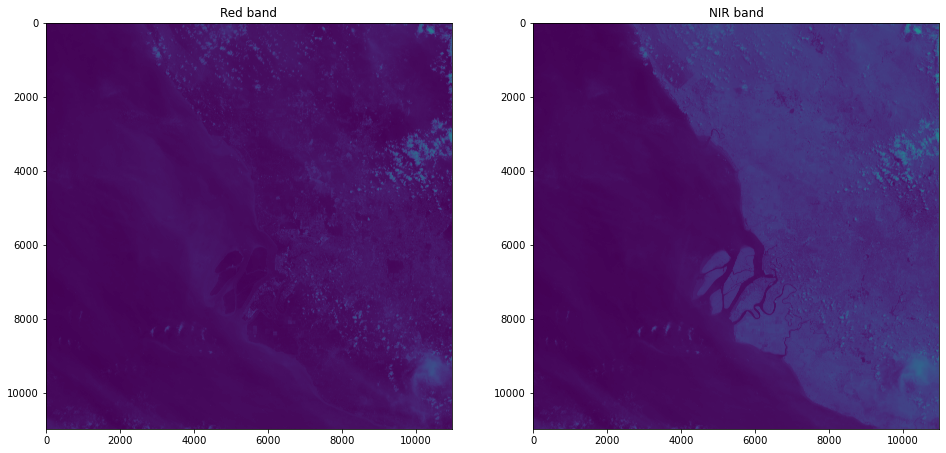

In [23]:
fig, axs = plt.subplots(1, 2, figsize=[16, 8])
axs[0].imshow(red_array)
axs[0].set_title('Red band')
axs[1].imshow(nir_array)
axs[1].set_title('NIR band')

A simple approach to calculating the index for the entire scene would be to loop over all of the pixels for each of the bands and apply the formula to calculate NDVI at each pixel.

In [24]:
red_array = red_array.astype(np.float64)
nir_array = nir_array.astype(np.float64)

In [25]:
%%time
ndvi_res = np.empty_like(red_array)
for i in range(ndvi_res.shape[0]):
    for j in range(ndvi_res.shape[1]):
        ndvi_res[i, j] = (nir_array[i, j] - red_array[i, j]) / (nir_array[i, j] + red_array[i, j])
        
# This will take a few minutes to run.

CPU times: user 4min 36s, sys: 698 ms, total: 4min 36s
Wall time: 4min 36s


The calculations in this form take around 4-5 minutes to run because we are operating on one pixel at a time. Re-writing the above function in a vectorized way will significantly reduce the time it takes to run.

Since we are working with NumPy arrays we can do the above calculation with NumPy as:

In [26]:
ndvi_res_vec = (nir_array - red_array) / (nir_array + red_array)

and comparing timings:

In [27]:
%%timeit
ndvi_res_vec = (nir_array - red_array) / (nir_array + red_array)

1.21 s ± 81.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We see that it runs over 200 times faster!

Now that the code has been written in this vectorized format, it is easy to add the vectorize decorator and compile with Numba.

In [28]:
@njit
def ndvi(red, nir):
    return (nir - red) / (nir + red)

@vectorize
def get_ndvi(red, nir):
    return ndvi(red, nir)

In [29]:
ndvi_res_numba = get_ndvi(red_array, nir_array)

Comparing timings:

In [30]:
%%timeit
ndvi_res_numba = get_ndvi(red_array, nir_array)

546 ms ± 13.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


So we are able to cut the time in half again using Numba.

Let's take a look at the results to ensure we are still getting the expected values.

Text(0.5, 1.0, 'NDVI using Numba')

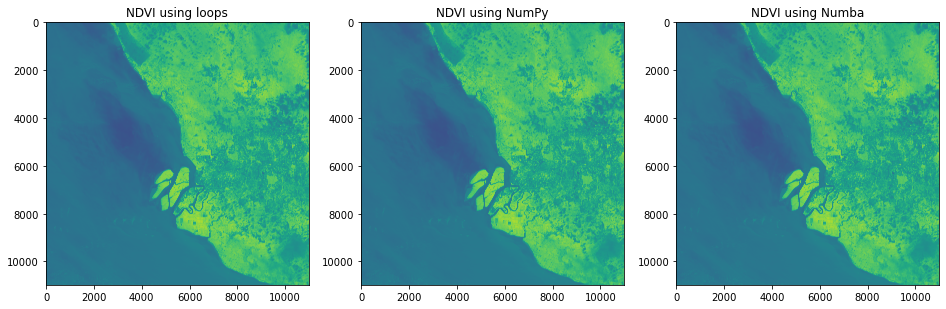

In [31]:
fig, axs = plt.subplots(1, 3, figsize=[16, 8])
axs[0].imshow(ndvi_res)
axs[0].set_title('NDVI using loops')
axs[1].imshow(ndvi_res_vec)
axs[1].set_title('NDVI using NumPy')
axs[2].imshow(ndvi_res_numba)
axs[2].set_title('NDVI using Numba')

You now have enough information to potentially speed up many of your existing workflows. In some cases it will be as simple as importing `numba` and adding the `@jit` decorator to some of your functions.

Read on to see how you can benefit from running your code on a GPU.

<a id="numba_gpu"></a>

## Numba for CUDA GPUs

Numba supports CUDA GPU programming by directly compiling Python code into CUDA kernels and device functions following the CUDA execution model. As with running Numba on the CPU, not all Python code is supported. For CUDA Python, you can see the full list of supported features here: [Supported Python features in CUDA Python](https://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html)

One of the main differences you will see between the supported features running on the CPU vs GPU are the limited NumPy methods supported for the GPU, as Numba disallows any memory allocating features for CUDA kernels.

Some key terms for CUDA programming that will be used in this sectoion are listed here:
 * _host_: the CPU
 * _device_: the GPU
 * _kernels_: a GPU function launched by the host and executed on the device
 * _device function_: a GPU function executed on the device which can only be called from the device (i.e. from a kernel or another device function)

We have seen how we can use the `vectorize()` and `guvectorize()` decorators on the CPU to create ufuncs. With a very small modification, these decorators can be used to run functions on a GPU. However, CUDA Vectorize and GUVectorize cannot produce a conventional ufunc and instead return a ufunc-like object. This object is a close analog but not fully compatible with a regular NumPy ufunc.

### CUDA ufunc-like objects

Let's take the simple addition function we used to demonstrate `@vectorize` on the CPU.

In [32]:
import numpy as np
from numba import vectorize

In [33]:
@vectorize
def f(x, y):
    return x + y

As with the CPU example seen earlier, we can use the type signature with this decorator. We can also change the default `target` option. Switching to `target='cuda'` will run our function on a GPU.

Below the `float32` outside of the brackets represents the output type and the `float32` types listed within the brackets are the types of each input argument.

In [34]:
@vectorize(['float32(float32, float32)'], target='cuda')
def f(x, y):
    return x + y

In [35]:
a = np.arange(12, dtype=np.float32).reshape(3, 4)
b = np.arange(12, dtype=np.float32).reshape(3, 4)

f(a, b)

array([[ 0.,  2.,  4.,  6.],
       [ 8., 10., 12., 14.],
       [16., 18., 20., 22.]], dtype=float32)

When using the type signature, we must ensure that we pass the correct variable types to the function. See what happens when we try to pass integer arrays to our function when it is expecting floats:

In [36]:
a = np.arange(12).reshape(3, 4)
b = np.arange(12).reshape(3, 4)

f(a, b)

TypeError: No matching version.  GPU ufunc requires array arguments to have the exact types.  This behaves like regular ufunc with casting='no'.

### Memory management

In our above example, Numba is automatically transfering the NumPy arrays to and from the device. The input arrays are copied to the device and arrays are copied back to the host when the kernel finishes. Where the arrays are read-only, this transfer is unnecessary. There may also be cases where you run several kernels, passing the output from one as an input to the next, and only need the output from the final kernel. If we rely on Numba to automatically handle our transfers, there will be extra copying carried out between each kernel that is not needed.

You can use the following APIs to manually control the transfer:
* `numba.cuda.device_array()` - to create an array on the device
* `numba.cuda.to_device()` - to copy a host array to the device

In the following example the inputs to our simple addition function are manually copied to the device and an output device array is created before running the function. We then pass the arrays that are already on the device to the function.

In [37]:
from numba import cuda

In [38]:
n = 1000000
a = np.arange(n).astype(np.float32)
b = 2 * a

We can compare the time taken to run the function using the automatic array transfers:

In [39]:
%timeit f(a, b)

8.11 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


with the manual copying of arrays:

In [40]:
a_device = cuda.to_device(a)
b_device = cuda.to_device(b)

out_device = cuda.device_array(shape=(n,), dtype=np.float32)

In [41]:
%timeit f(a, b, out=out_device)

8.09 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


The output can be copied back to the host if/when it is needed:

In [42]:
out_host = out_device.copy_to_host()

As expected the function runs faster when the arrays are already on the device. In this simple example the manual copying does not lead to dramatically faster timings. However there are cases where this type of memory management can have a huge impact on speed. For example when looping over a kernel we can wait until all loops have been completed before copying back a final result, rather than carrying out slow tranfers in every loop.

### Example: Applying NDVI to Sentinel 2 data using a GPU

We saw in our ealier CPU examples that functions with the `@jit` decorator can be used within other JITed functions or vectorized functions. The same is true when running on GPUs, but in this case we need to use the `@cuda.jit` decorator and turn it into a device function using the `device=True` option. CUDA device functions can only be called from other device functions or via a kernel.

Using the NDVI example, we can demonstrate the changes needed to go from running on the CPU to running on a GPU.

Below we will replace the `@njit` decorator with the `@cuda.jit` decorator. We will also add the `target='cuda'` option to the vectorize decorator.

In [43]:
@cuda.jit(device=True)
def ndvi(red, nir):
    return (nir - red) / (nir + red)

@vectorize(['float64(float64, float64)'], target='cuda')
def get_ndvi(red, nir):
    return ndvi(red, nir)

In [44]:
red_device = cuda.to_device(red_array)
nir_device = cuda.to_device(nir_array)

out_device = cuda.device_array_like(red_device)

We have created an output array to pass to the function, which the result will be written to on the device.

In [45]:
get_ndvi(red_device, nir_device, out=out_device)

The result can be copied back to the host ready for plotting.

In [46]:
out_host = out_device.copy_to_host()

Let's confirm that we get the same results when running on the GPU.

Text(0.5, 1.0, 'NDVI on GPU')

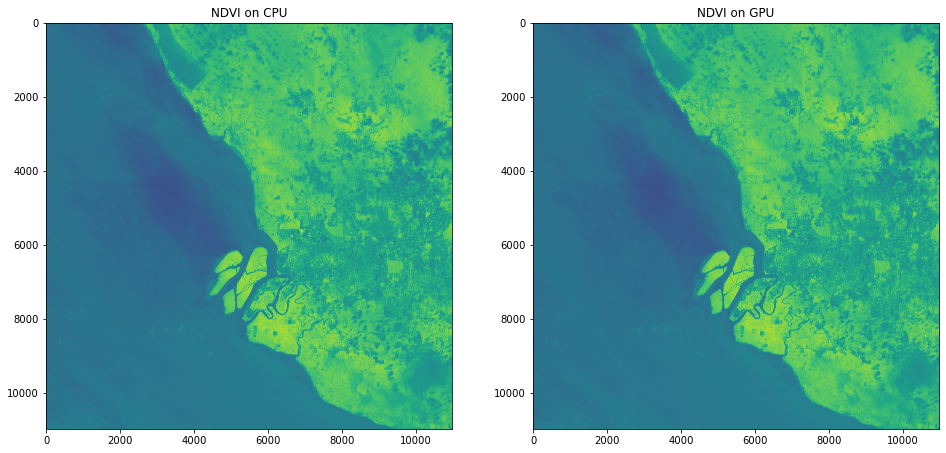

In [47]:
fig, axs = plt.subplots(1, 2, figsize=[16, 8])
axs[0].imshow(ndvi_res)
axs[0].set_title('NDVI on CPU')
axs[1].imshow(out_host)
axs[1].set_title('NDVI on GPU')

Have we gained any increase in speed by moving the processing to the GPU?

In [48]:
%timeit get_ndvi(red_device, nir_device, out=out_device)

3.89 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The function now runs in about 4ms. That's over 100 times faster than using Numba on the CPU and over 50,000 times as fast as the original looping solution!

You can actually speed things up further by converting the data to `float32` from `float64` which runs slowly on a GPU.

In [49]:
@vectorize(['float32(float32, float32)'], target='cuda')
def get_ndvi(red, nir):
    return ndvi(red, nir)

red_array = red_array.astype(np.float32)
nir_array = nir_array.astype(np.float32)

red_device = cuda.to_device(red_array)
nir_device = cuda.to_device(nir_array)

out_device = cuda.device_array_like(red_device)
# Run the function once before timing it to allow Numba to compile the function.
get_ndvi(red_device, nir_device, out=out_device)

%timeit get_ndvi(red_device, nir_device, out=out_device)

2.03 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<a id="cupy"></a>

## Introduction to CuPy

We will now look at another useful tool for porting code to GPUs - CuPy. This is the perfect tool to use if you make a lot of use of NumPy in your code. If you know how to use NumPy, you can use CuPy. In theory you can port your code to run on a GPU by changing a single line of code. There are some differences between NumPy and CuPy as discussed in the documentation: [Difference between CuPy and NumPy](https://docs.cupy.dev/en/stable/user_guide/difference.html) and you may need to make some minor modifications to your code to get it to run with CuPy instead of NumPy.

The convention for importing CuPy is to use the abbreviation `cp`, just as we import `numpy` as `np`.

In [50]:
import numpy as np
import cupy as cp

CuPy has an `ndarray` class that replaces Numpy's `ndarray` class.

In [51]:
x_cpu = np.array([1, 2, 3])
x_gpu = cp.array([1, 2, 3])

In [52]:
print(type(x_cpu))
print(type(x_gpu))

<class 'numpy.ndarray'>
<class 'cupy.core.core.ndarray'>


We can also apply many of the same functions to the CuPy arrays as we would typically use with a NumPy array.

In [53]:
print(np.average(x_cpu))
print(cp.average(x_gpu))

2.0
2.0


The main difference between the two arrays is that the CuPy array is stored on the _current device_, which is the default GPU device where the array operations take place. The NumPy array is stored on the host.

If you need to move NumPy or CuPy arrays to the same location the methods `cupy.asarray()` and `cupy.asnumpy()` are available to do so.

In [54]:
x_cpu = np.array([1, 2, 3])
x_gpu = cp.asarray(x_cpu)  # move the data to the current device.

In [55]:
print(type(x_cpu))
print(type(x_gpu))

<class 'numpy.ndarray'>
<class 'cupy.core.core.ndarray'>


In [56]:
x_gpu = cp.array([1, 2, 3])  # create an array on the current device
x_cpu = cp.asnumpy(x_gpu)  # move the array to the host.

In [57]:
print(type(x_cpu))
print(type(x_gpu))

<class 'numpy.ndarray'>
<class 'cupy.core.core.ndarray'>


Where the two libraries share the same API, it is possible to port a piece of code to run on a GPU by changing one line of code, e.g. the following piece of code uses NumPy to carry out some basic operations on ndarrays:

In [58]:
import numpy as np

n = 1000

a = np.arange(n*n).reshape(n, n)
b = np.ones_like(a)

c = np.sqrt(a + b)
c_avg = np.average(c, axis=0)

max_avg = np.max(c_avg)

print(max_avg)
print(type(max_avg))


667.1601343936815
<class 'numpy.float64'>


Let's time how long it takes to complete these operations with Numpy:

In [59]:
%%timeit

n = 1000

a = np.arange(n*n).reshape(n, n)
b = np.ones_like(a)

c = np.sqrt(a + b)
c_avg = np.average(c, axis=0)

max_avg = np.max(c_avg)

9.33 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


By importing CuPy as `np` we can run the same code on a GPU:

In [60]:
import cupy as np  # changing this line only allows the code to run on a GPU

n = 1000

a = np.arange(n*n).reshape(n, n)
b = np.ones_like(a)

c = np.sqrt(a + b)
c_avg = np.average(c, axis=0)

max_avg = np.max(c_avg)

print(max_avg)
print(type(max_avg))

667.1601343936818
<class 'cupy.core.core.ndarray'>


In [61]:
%%timeit

n = 1000

a = np.arange(n*n).reshape(n, n)
b = np.ones_like(a)

c = np.sqrt(a + b)
c_avg = np.average(c, axis=0)

max_avg = np.max(c_avg)

262 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


By changing this one line of code, we are able to run the same calculations about 40 times as fast. Note that the results running on the CPU vs GPU are slightly different (see last digit). In some cases the underlying methods used by NumPy and CuPy will differ leading to slight differences in accuracy.

### CuPy Custom Kernels

As well as using CuPy as a drop in replacement for NumPy to run on a GPU, there are a number of other useful tools that come with CuPy including methods for writing user-defined CUDA kernels. Writing your own CUDA kernel can be complicated, so CuPy provides easy ways to define three types of CUDA kernels: elementwise kernels, reduction kernels and raw kernels. Below we look at an example of using CuPy's `ElementwiseKernel` class.

To define an elementwise kernel we need to pass four arguments to `cp.ElementwiseKernel()`:
 * an input argument list,
 * an output argument list,
 * a loop body code,
 * and the kernel name.
 
Each of these arguments is a string. The input argument list and output argument list both consist of comma-separated argument definitions. These definitions are made up of the argument type and the argument name. The loop body code defines how the output is calculated as a function of the inputs.

For example, a kernel that computes a squared difference is defined as follows:

In [62]:
squared_diff = cp.ElementwiseKernel(
   'float32 x, float32 y',
   'float32 z',
   'z = (x - y) * (x - y)',
   'squared_diff')

The above kernel takes two inputs, `x` and `y`, that are both of type `float32`, and returns the `float32` output `z`. It can be called on either scalars or arrays with broadcasting:

In [63]:
x = cp.arange(10, dtype=cp.float32).reshape(2, 5)
y = 5

squared_diff(x, y)

array([[25., 16.,  9.,  4.,  1.],
       [ 0.,  1.,  4.,  9., 16.]], dtype=float32)

In [64]:
x = cp.arange(10, dtype=np.float32).reshape(2, 5)
y = cp.arange(5, dtype=np.float32)

squared_diff(x, y)

array([[ 0.,  0.,  0.,  0.,  0.],
       [25., 25., 25., 25., 25.]], dtype=float32)

<a id="numba_cupy"></a>

## Using Numba and CuPy together

`cupy.ndarray` implements `__cuda_array_interface__`, which is the CUDA array interchange interface compatible with Numba v0.39.0 or later. This means you can pass CuPy arrays to kernels JITed with Numba. Using CuPy arrays with Numba can simplify the process of copying arrays to and from the device.

Again we will use the NDVI example, this time to show how Numba and CuPy can be used together.

In [65]:
import cupy as cp
from numba import cuda, vectorize

In [66]:
# Copied from earlier example:
@cuda.jit(device=True)
def ndvi(red, nir):
    return (nir - red) / (nir + red)

@vectorize(['float32(float32, float32)'], target='cuda')
def get_ndvi(red, nir):
    return ndvi(red, nir)

In [67]:
# Convert our numpy input arrays to cupy arrays and create cupy array for output:
gpu_red = cp.asarray(red_array, dtype=cp.float32)
gpu_nir = cp.asarray(nir_array, dtype=cp.float32)
gpu_out = cp.zeros_like(gpu_red)

In [68]:
# Pass these cupy arrays, that exist on the device, to the kernel:
get_ndvi(gpu_red, gpu_nir, out=gpu_out)

In [69]:
type(gpu_out)

cupy.core.core.ndarray

Text(0.5, 1.0, 'NDVI with Numba and CuPy')

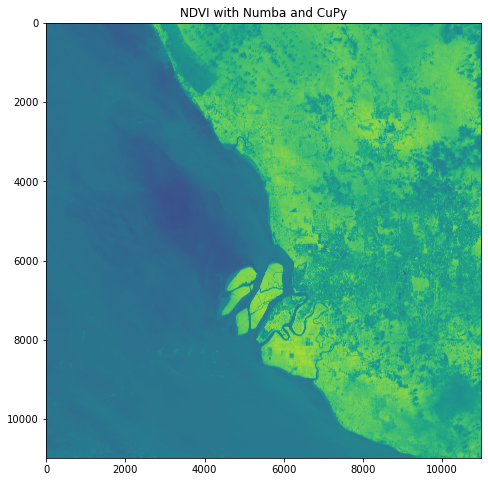

In [70]:
# Convert output to a numpy array ready for plotting:
cpu_out = cp.asnumpy(gpu_out)

fig, ax = plt.subplots(figsize=[16, 8])
ax.imshow(cpu_out)
ax.set_title('NDVI with Numba and CuPy')

In [71]:
%timeit get_ndvi(gpu_red, gpu_nir, out=gpu_out)

3.52 ms ± 49 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Using CuPy with the Numba vectorized function still gives us similar times as before.

<a id="nanpercentile"></a>

## Accelerating Numpy's nanpercentile function

In this section we will take what we have learned in the previous sections and apply it to a common operation that is known to be slow for large datasets.

If you have ever had to calculate percentiles for a dataset containing NaNs, you may well have used NumPy's `nanpercentile()` function. For smaller datasets it can work well, but as the dataset grows this function can take a very long time to run.

There was a blog post a few years ago that looked at this very problem, which you can find [here](https://krstn.eu/np.nanpercentile()-there-has-to-be-a-faster-way/). In this blog they proposed an alternative pure Python implementation of the quantile calculation with the following steps:
 * find the number of valid observations (non NaN)
 * replace NaN with maximum value of array
 * sort values along axis
 * find position of quantile regarding number of valid observations
 * linear interpolation if the desired quantile is inbetween two positions (like numpys linear interpolation)

You can find the code from this blog in the `nanpercentile_functions.ipynb` notebook, which we will import below to allow us to compare timings.

We can use a similar approach to speed things up with a GPU using Numba and CuPy, and in particular the `guvectorize` decorator. To demonstrate this we'll generate a test array with shape 20 x 500 x 500 and calculate a 500 x 500 array of the 90th percentile values.

First we'll import all the required modules and functions that are needed in this section.

In [72]:
import math

import numpy as np
import cupy as cp
from numba import cuda, njit, guvectorize

In [73]:
# Run the nanpercentile_functions notebook so that we have access to the gpu_quickSortIterative function
# to be used in our GPU solution and the nan_percentile function used in the blog:
%run nanpercentile_functions.ipynb

In [74]:
# Create an image of size 500x500 with 20 layers, ie. array of shape (20,500,500)
test_arr = np.random.randint(0, 250000, 5000000).reshape(20,500,500).astype(np.float32)
np.random.shuffle(test_arr)
# place random NaN
rand_nan = np.random.randint(0, 5000000, 5000).astype(np.float32)
for r in rand_nan:
    test_arr[test_arr == r] = np.nan

Let's see how long it takes to calculate the 90th percentiles for the test array using Numpy's `nanpercentile` function. You may wish to try different sized arrays above to see the impact it can have on run times, or read in some of your own real-life data to experiment with.

In [75]:
input_arr = np.array(test_arr, copy=True)
numpy_nan = np.nanpercentile(input_arr, q=[90], axis=0)

In [76]:
%%timeit
input_arr = np.array(test_arr, copy=True)
np.nanpercentile(input_arr, q=[90], axis=0)
# this will take a few minutes to run

22.6 s ± 338 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We can see that the pure Python alternative described by the blog post does a good job of speeding things up:

In [77]:
input_arr = np.array(test_arr, copy=True)
cpu_blog_nan = nan_percentile(input_arr, q=[90])  # nan_percentile is defined in the nanpercentile_functions.ipynb notebook

In [78]:
%%timeit
input_arr = np.array(test_arr, copy=True)
nan_percentile(input_arr, q=[90])

125 ms ± 819 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let us now apply what we have learned in this notebook to see if we can do any better with a GPU. We will write a pure Python implementation of the 90th percentile calculation. This could be extended to calculate arbitrary percentiles, but for the purposes of this notebook we shall keep things as simple as possible.

We will make use of the `guvectorize` decorator. The operation being perfomed by the decorated function will be to calculate the 90th percentile of a 1 dimensional array. By using the `guvectorize`, we can pass higher dimensional arrays to the function and Numba will handle running the operation across all dimensions.

The main function will also make use of 2 device functions:
* `gpu_quickSortIterative` - this is defined in `nanpercentile_functions.ipynb` and used to sort the 1D array on the device. 
* `gpu_calc_90_quant` - this is defined below and is used to calculate the quantile values.


In [79]:
@cuda.jit(device=True)
def gpu_calc_90_quant(k_arr, f_arr, c_arr, f_val, c_val):
    '''
    Calculate the 90th quantile.
    
    Args:
     * k_arr - desired quantile position
     * f_arr - floor value of k_arr
     * c_arr - ceiling value of k_arr
     * f_val - value in input array at position [f_arr]
     * c_val - value in input array at postion [c_arr]
    '''
    if f_arr == c_arr:
        quant_val = f_val
    else:
        floor_frac = c_arr - k_arr
        floor_frac_val = f_val * floor_frac

        ceil_frac = k_arr - f_arr
        ceil_frac_val = c_val * ceil_frac

        quant_val = floor_frac_val + ceil_frac_val

    return quant_val

@guvectorize(['float32[:], int32[:], int32[:], float32[:], float32[:]'],
             '(p), (i), (i), (i) -> ()', target='cuda')
def gpu_get_nan_perc(max_val, stack, ids, arr, quant90):
    '''
    This function requires the following arguments:
    
    * max_val - Maximum value of input array
    * stack - An array of zeros in the same shape as input array.
              It is used by the sorting kernel.
    * ids - An array of zeros in the same shape as input array.
            It is used by the sorting kernel.
    * arr - The input array for which we want to calculate the
            90th percentile.
            
    output: quant90 - a 0D array containing 90th percentile result.
    
    '''
    valid_obs = 0
    for i in range(arr.shape[-1]):
        if math.isfinite(arr[i]):
            # Count the number of valid observations to be used
            # to determine quantile position.
            valid_obs += 1
        else:
            # Replace NaNs with the maximum value of the array.
            arr[i] = max_val[0]

    # Sort the array using device function.
    # NaNs, having been replaced with the max value will all be shifted to the
    # right of the array.
    gpu_quickSortIterative(arr, stack, ids)

    # Calculate the inputs for the gpu_calc_90_quant function.
    k_arr = (valid_obs - 1) * 0.9
    f_arr = int(math.floor(k_arr))
    c_arr = int(math.ceil(k_arr))
    f_val = arr[f_arr]
    c_val = arr[c_arr]

    # The output is a zero dimensional array containing the 90th percentile value.
    quant90[0] = gpu_calc_90_quant(k_arr, f_arr, c_arr, f_val, c_val)

Note that the output is a zero dimensional array and the result must be assigned to the zero index.

Our test array has the dimension that we want to calculate the percentiles for as the first axis. `np.nanpercentile` can take an axis argument and handle this. The blog version is specifically written to collapse over the first axis, but not handle doing the calculation over different axes.

For the guvectorize solution to work we want the percentiles to be calculated for the last dimension. So we'll need to swap the axis of our input array to apply the function to it (this step could alternatively be carried out in the nan_percentile function with options to choose the axis like NumPy's version).

In [80]:
input_arr = np.array(test_arr, copy=True)
# Re-order the axes so that we can apply the percentiles calculation over the last dimension
input_arr = np.rollaxis(input_arr, 0, 3)
# Convert our NumPy array to a CuPy array
input_arr = cp.asarray(input_arr)

# Make CuPy arrays for remaining inputs
my_stack = cp.zeros_like(input_arr, dtype=cp.int32)
my_ids = cp.zeros_like(input_arr, dtype=cp.int32)
max_val = cp.nanmax(input_arr, axis=2).reshape(input_arr.shape[0], input_arr.shape[1], 1)

# Run our function passing the cupy arrays as arguments
gpu_nan = gpu_get_nan_perc(max_val, my_stack, my_ids, input_arr)

In [81]:
%%timeit
input_arr = np.array(test_arr, copy=True)
input_arr = np.rollaxis(input_arr, 0, 3)
input_arr = cp.asarray(input_arr)
my_stack = cp.zeros_like(input_arr, dtype=cp.int32)
my_ids = cp.zeros_like(input_arr, dtype=cp.int32)
max_val = cp.nanmax(input_arr, axis=2).reshape(input_arr.shape[0], input_arr.shape[1], 1)
gpu_get_nan_perc(max_val, my_stack, my_ids, input_arr)

19.2 ms ± 297 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


This is much faster than running on the CPU:
about 7 x faster than the solution provided in the blog post and over 1000 x faster than Numpy's nanpercentile function!

We should confirm that the results are as expected.

In [82]:
np.allclose(numpy_nan, cpu_blog_nan), np.allclose(numpy_nan, gpu_nan)

(True, True)

We have now seen how Numba and CuPy can be used to speed up array operations. As problems become larger these performance gains can become more important e.g. code that takes several hours to run can be run in a matter of seconds. These kind of improvements are often possible for math-heavy code that can be run in parallel.

In some cases we can see performance improvements by changing a single line of code. In other cases such as the percentiles problem, the code may need to be re-written to get the benefits of using the GPUs.

<a id="next_steps"></a>

## Next steps

The tools covered in this notebook are just a taste of what is possible with Numba and CuPy and there are lots of nice features that you may wish to explore a bit further in the user documentation:
 * [Numba Documentation](https://numba.readthedocs.io/en/stable/index.html)
 * [CuPy Documentation](https://docs.cupy.dev/en/stable/index.html)

In this notebook we have been using Numba and CuPy to decide for us how to execute our code. For example we haven't had to think about how many threads to run on, or what is running on each thread. For more complicated problems that cannot be written as ufuncs we need to understand a bit more about the CUDA programming model. There are more details about writing CUDA kernels with Numba here:

* https://numba.readthedocs.io/en/stable/cuda/kernels.html

and writing CUDA kernels with CuPy here:

* https://docs.cupy.dev/en/stable/user_guide/kernel.html#raw-kernels

You can find out more about the CUDA programming model here:

* https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#introduction
* https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#programming-model

Rather than writing your own CUDA kernels, you may want to see if what you need has already been written. You can find some examples of existing libraries that are based on CUDA here:

* https://rapids.ai/
* https://developer.nvidia.com/gpu-accelerated-libraries